## CSML1010 Group3 Course_Project - Milestone 2 - Baseline Machine Learning Implementation
#### Authors (Group3): Paul Doucet, Jerry Khidaroo
#### Project Repository: https://github.com/CSML1010-3-2020/NLPCourseProject

#### Dataset:
The dataset used in this project is the __Taskmaster-1__ dataset from Google.
[Taskmaster-1](https://research.google/tools/datasets/taskmaster-1/)

The dataset can be obtained from: https://github.com/google-research-datasets/Taskmaster

---

## Workbook Setup and Data Preparation

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.7f}'.format
pd.options.display.precision = 7
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [3]:
df_all = pd.read_csv('./data/dialog_norm.csv')
df_all.columns

Index(['Instruction_id', 'category', 'selfdialog_norm'], dtype='object')

In [4]:
df_all.head(3)

,Instruction_id,category,selfdialog_norm
0,restaurant-table-2,0,hi im looking book table korean fod ok area thinking somewhere southern nyc maybe east village ok great theres thursday kitchen great reviews thats great need table tonight pm people dont want sit bar anywhere else fine dont availability pm times available yikes cant times ok second choice let check ok lets try boka free people yes great lets book ok great requests thats book great use account open yes please great get confirmation phone soon
1,movie-tickets-1,1,hi would like see movie men want playing yes showing would like purchase ticket yes friend two tickets please okay time moving playing today movie showing pm okay anymore movies showing around pm yes showing pm green book two men dealing racisim oh recommend anything else like well like movies funny like comedies well like action well okay train dragon playing pm okay get two tickets want cancel tickets men want yes please okay problem much cost said two adult tickets yes okay okay anything else help yes bring food theater sorry purchase food lobby okay fine thank enjoy movie
2,movie-tickets-3,2,want watch avengers endgame want watch bangkok close hotel currently staying sounds good time want watch movie oclock many tickets two use account already movie theater yes seems movie time lets watch another movie movie want watch lets watch train dragon newest one yes one dont think movie playing time either neither choices playing time want watch afraid longer interested watching movie well great day sir thank welcome


#### Remove NaN rows

In [5]:
print(df_all.shape)
df_all = df_all.dropna()
df_all = df_all.reset_index(drop=True)
print(df_all.shape)

(7708, 3)
(7705, 3)


In [6]:
print (df_all.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    1160
coffee-ordering-1      735
coffee-ordering-2      641
movie-finder            54
movie-tickets-1        678
movie-tickets-2        377
movie-tickets-3        195
pizza-ordering-1       257
pizza-ordering-2      1210
restaurant-table-1     704
restaurant-table-2     494
restaurant-table-3     102
uber-lyft-1            646
uber-lyft-2            452
dtype: int64


In [7]:
#print (df_all.groupby('Instruction_id').size())
#weight_higher = ['restaurant-table-2', 'movie-tickets-1', 'movie-tickets-3','uber-lift-2','coffee-ordering-1','coffee-ordering-2','pizza-ordering-2','movie-finder']
# weight_higher = ['restaurant-table-2', 'movie-tickets-1', 'movie-tickets-3','uber-lift-2','coffee-ordering-1','coffee-ordering-2','movie-finder']
# weight_lower = ['auto-repair-appt-1', 'pizza-ordering-2']
class_sample_size_dict = {
    "auto-repair-appt-1": 250,
    "coffee-ordering-1": 250,
    "coffee-ordering-2": 450,
    "movie-finder": 54,
    "movie-tickets-1": 450,
    "movie-tickets-2": 250,
    "movie-tickets-3": 195,
    "pizza-ordering-1": 250,
    "pizza-ordering-2": 450,
    "restaurant-table-1": 250,
    "restaurant-table-2": 450,
    "restaurant-table-3": 102,
    "uber-lyft-1": 250,
    "uber-lyft-2": 450
}

#### Get a Sample of records.

In [8]:
cat_id_df = df_all[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
cat_count = len(cat_id_df)
sample_size = 4000
sample_per_cat = sample_size//cat_count
print('sample_size: ', sample_size, 'sample_per_cat: ', sample_per_cat)

sample_size:  4000 sample_per_cat:  285


In [9]:
# Function to Get balanced Sample - Get a bit more than needed then down sample
def sampling_k_elements(group, k=sample_per_cat):
    if len(group) < k:
        return group
    name = group['Instruction_id'].iloc[0]
    k = class_sample_size_dict[name]
    return group.sample(k, random_state=5)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to sample_size
corpus_df = corpus_df.sample(n=sample_size, random_state=3)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    246
coffee-ordering-1     246
coffee-ordering-2     436
movie-finder           52
movie-tickets-1       441
movie-tickets-2       242
movie-tickets-3       189
pizza-ordering-1      251
pizza-ordering-2      435
restaurant-table-1    246
restaurant-table-2    437
restaurant-table-3     99
uber-lyft-1           244
uber-lyft-2           436
dtype: int64


In [10]:
# imblearn.over_sampling import SMOTE

# # for reproducibility purposes
# seed = 100
# # SMOTE number of neighbors
# k = 1

# #df = pd.read_csv('df_imbalanced.csv', encoding='utf-8', engine='python')
# # make a new df made of all the columns, except the target class
# X = df_all.loc[:, df.columns != 'Instruction_id']
# y = df_all.Instruction_id
# sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)
# X_res, y_res = sm.fit_resample(X, y)

# plt.title('Dataset balanced with synthetic or SMOTE'd data ({} neighbors)'.format(k))
# plt.xlabel('x')
# plt.ylabel('y')
# plt.scatter(X_res[:, 0], X_res[:, 1], marker='o', c=y_res,
#            s=25, edgecolor='k', cmap=plt.cm.coolwarm)
# plt.show()

# df_all = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
# # rename the columns
# df_all.columns = ['feature_1', 'feature_2', 'label']
# #df_alldf.to_csv('df_smoted.csv', index=False, encoding='utf-8')

#### Generate Corpus List

In [11]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm)

print(len(doc_lst))
doc_lst[1:5]

4000


['hi im way home want pick pizza put together course want place order patsys pizza one upper west side account right people coming games night okay im website order want two pizza di parma bigger size two inch pizza di parma else would like inch bacon peppers onions im looking menu dont see bacon prosciutto sausage pepperoni okay make sausage need one vegetarians thats green arugula broccoli sundried tomatoes might like great one broccoli mushroom sundried tomatoes one inch broccoli sundried tomato mushroom sides appetizers salad eating crowd big mixed salad big caesar salad thats one family size insalata mista one family size insalata romana says dressing comes mixed please ask put dressing side ill make note anything else want add okay putting say pick minutes thanks great night youre welcome see tomorrow',
 'hey find fancy steak house seattle dinner yeah course want chain restaurant something unique seattle something unique seattle two top rated steak houses kings steak georges tell

#### Split Data into Train and Test Sets

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['category'], test_size=0.25, random_state = 0)

#### Build Vocabulary

In [13]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(X_train)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in X_train]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.


Vocabulary Size: 10391
Vocabulary Sample: [('like', 1), ('would', 2), ('okay', 3), ('ok', 4), ('yes', 5), ('want', 6), ('order', 7), ('pm', 8), ('thank', 9), ('please', 10)]


### Bag of Words Feature Extraction

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(X_train, y_train)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 4, 4, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 5, 4, ..., 1, 1, 0],
       [0, 4, 2, ..., 0, 0, 1]], dtype=int64)

In [15]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,okay,ok,yes,want,order,pm,thank,please,pizza,one,tickets,great,...,operating,armandos,liek,yw,athenaeum,nashua,restaurante,ifc,canyon,agora,jeremy,workso,somee,reaelly,twins
0,0,4,4,0,1,4,3,0,1,1,0,0,0,3,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,3,0,1,1,4,0,1,3,6,1,0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,4,1,4,4,0,1,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,3,3,3,2,0,2,0,4,1,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,6,6,0,0,2,1,1,6,1,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,5,4,2,0,2,2,0,0,1,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2996,0,0,3,1,4,2,1,0,0,1,2,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0
2997,0,1,1,5,0,0,3,0,2,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2998,0,5,4,0,3,0,3,3,0,1,1,0,3,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [16]:
# Get BOW features
X_train_bow = cv_matrix #cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(3000, 10391)
(1000, 10391)
(1000,)


#### Define Model Builder Function

In [17]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

class Result_Metrics:
    def __init__(self, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)

    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()
    precision = metrics.precision_score(labels_test, pred, average='weighted')
    recall = metrics.recall_score(labels_test, pred, average='weighted')
    
    rm = Result_Metrics(pred, cm, report, f1, accuracy, precision, recall)

    return rm

### Bag of Words Feature Benchmarking Baseline with Naive Bayes Classifier

In [18]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
rm_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [19]:

def Save_Benchmark(descr, feat_type, b_metrics, reset_rb, reset_rb_all):
    global rows_benchmarks
    global rows_benchmarks_all
    global df_benchmarks
    global df_benchmarks_all
    if (reset_rb):
        rows_benchmarks = []

    if (reset_rb_all):
        rows_benchmarks_all = []
    rows_benchmarks.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    rows_benchmarks_all.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])
    df_benchmarks_all = pd.DataFrame(rows_benchmarks_all, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])


In [20]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Baseline", "BOW", rm_nb_bow, True, True)
#df_benchmarks

In [21]:
from sklearn.metrics import confusion_matrix
#rm_nb_bow.cm

In [22]:
from sklearn import metrics
#print("Label" + rm_nb_bow.report)

### Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Functions

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

class Result_Metrics_selected:
    def __init__(self, x_train_sel, x_test_sel, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.x_train_sel = x_train_sel
        self.x_test_sel = x_test_sel
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Get_Scaled_Features(features_train, labels_train, features_test, labels_test, scaler):
    x_train_scaled = scaler.fit_transform(features_train, labels_train)
    x_test_scaled = scaler.transform(features_test)
    return x_train_scaled, x_test_scaled

def Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test):
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(features_train, labels_train)
    chi_support = chi_selector.get_support()    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    return X_train_chi, X_test_chi

def Get_Model_Feature_Metrics(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_train_chi, X_test_chi = Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test)
    x_train_scaled, x_test_scaled = Get_Scaled_Features(X_train_chi, labels_train, X_test_chi, labels_test, scaler)
    rm_chi = Build_Model(model, x_train_scaled, labels_train, x_test_scaled, labels_test)
    return rm_chi

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_norm = scaler.fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]

    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()
    precision_chi = metrics.precision_score(labels_test, predict_chi, average='weighted')
    recall_chi = metrics.recall_score(labels_test, predict_chi, average='weighted')
    
    rm_chi = Result_Metrics_selected(X_train_chi, X_test_chi, predict_chi, cm_chi, report_chi, f1_chi, accuracy_chi, precision_chi, recall_chi)

    return rm_chi

#### Iterate through number of features and get benchmark results

In [24]:
a = 100
tot = X_train_bow.shape[1]
b = 100 * (tot//100)
c = 100
print(a, b, c)

100 10300 100


In [25]:
rows = []

scaler_min_max = MinMaxScaler()
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    #rm_chi_i = Get_Model_Feature_Metrics(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


#### Plot f1-score by number of selected features

In [26]:
#acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [27]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
#acc_df.sort_values(by='f1_score', ascending=False).head(5)

350 450 1


#### Get a more fine-grained look at the optimal number of features region

In [28]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    #rm_chi_i = Get_Model_Feature_Metrics(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

In [29]:
#acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [30]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
#acc_df.sort_values(by='f1_score', ascending=False).head(5)

355


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [31]:
model_nb_bow_opt = MultinomialNB()
rm_chi_opt_bow = SelectBestModelFeatures_Chi(model_nb_bow, Opt_no_of_feat, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)

In [32]:
#print(rm_chi_opt_bow.cm)

In [33]:
#print("Label" + rm_chi_opt_bow.report)

In [34]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "BOW", rm_chi_opt_bow, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW Naive Bayes Baseline,BOW,0.7071427,0.6650000,0.5866020,0.6650000
1,BOW Naive Bayes Optimal Features Selected: 355,BOW,0.7067530,0.7160000,0.7016381,0.7160000


---

## 1. Benchmark Comparison

### Benchmark the following four models: Logistic Regression (Multinomial) Naive Bayes Linear Support Vector Machine Random Forest

#### Baseline Features

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

model_ids = ['RF', 'SVC', 'NB','LR']
models = [
    RandomForestClassifier(n_jobs=-1),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(n_jobs=-1),
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model, model_id in zip(models, model_ids):
    model_name = model.__class__.__name__
    f1_scores = cross_val_score(model, X_train_bow, y_train, scoring='f1_weighted', cv=CV)
    #precisions = cross_val_score(model, X_train_bow, y_train, scoring='precision_weighted', cv=CV)
    #recalls = cross_val_score(model, X_train_bow, y_train, scoring='recall_weighted', cv=CV)
    
    for i in range(0, 9, 1):
        entries.append((model_id, model_name, 'baseline', 'default', '', f1_scores[i]))

cv_df = pd.DataFrame(entries, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])       

#### Optimised Features

In [37]:

models = [
    RandomForestClassifier(n_jobs=-1),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(n_jobs=-1)
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
#entries = []

for model, model_id in zip(models, model_ids):
    model_name = model.__class__.__name__
    f1_scores = cross_val_score(model, rm_chi_opt_bow.x_train_sel, y_train, scoring='f1_weighted', cv=CV)
    #precisions = cross_val_score(model, rm_chi_opt_bow.x_train_sel, y_train, scoring='precision_weighted', cv=CV)
    #recalls = cross_val_score(model, rm_chi_opt_bow.x_train_sel, y_train, scoring='recall_weighted', cv=CV)

    for i in range(0, 9, 1):
        entries.append((model_id, model_name, 'optimized', 'default', '', f1_scores[i]))
        #entries.append((model_name, 'optimized', precisions[i], recalls[i], f1_scores[i]))

cv_df = pd.DataFrame(entries, columns=['Model_Id','Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])        

### Modeling

Four different models were verified as part of our modeling: 
+ Random Forest
+ Linear SVC
+ Multinomial Naïve Bayes
+ Logistic Regression 

The modeling was first done on our baseline features and using the selected optimised features identified as part of milestone 1: Naïve Bayes using Chi Squared.

In [38]:
models_df = cv_df.groupby(['Model_Id', 'Model','Features', 'Hyper_Param', 'Best_Params']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

F1_Score_mean
Model_Id Model                  Features  Hyper_Param Best_Params               
LR       LogisticRegression     baseline  default                      0.7412340
                                optimized default                      0.7308755
NB       MultinomialNB          baseline  default                      0.6233841
                                optimized default                      0.7424195
RF       RandomForestClassifier baseline  default                      0.5875110
                                optimized default                      0.6956293
SVC      LinearSVC              baseline  default                      0.7196469
                                optimized default                      0.7103931

## Optimize the Hyperparameters Using Grid Search

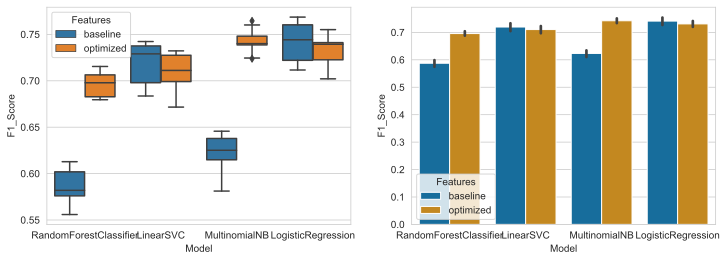

In [39]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2, sharex=True)
sns.boxplot(x='Model', y='F1_Score', data=cv_df, hue='Features', ax=ax1);
#sns.stripplot(x='Model', y='F1_Score', data=cv_df, hue='Features', size=6, jitter=True, edgecolor="gray", linewidth=2, ax=ax1);
sns.barplot(y='F1_Score', x='Model', data=cv_df, palette="colorblind", hue='Features', ax=ax2);


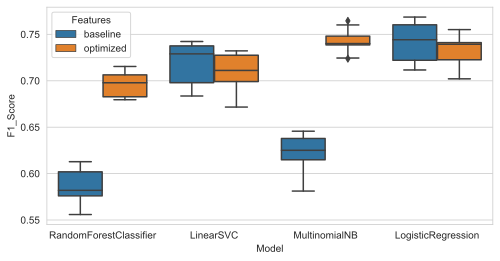

In [40]:
import seaborn as sns

fig, (ax1) = plt.subplots(figsize=(8, 4), ncols=1, sharex=True)
sns.boxplot(x='Model', y='F1_Score', data=cv_df, hue='Features', ax=ax1);

In [41]:
from sklearn.model_selection import GridSearchCV

class Estimator_Parameters:
    def __init__(self, estimator, parameters, feat_type, x, y):
        self.estimator = estimator
        self.parameters = parameters
        self.feat_type = feat_type
        self.x = x
        self.y = y

def Get_Best_Parameters(est_param):
    grid_search = GridSearchCV(estimator = est_param.estimator,
                            param_grid = est_param.parameters,
                            scoring = 'f1_weighted',
                            cv= 10,
                            n_jobs = -1)
    grid_search = grid_search.fit(est_param.x, est_param.y)
    return grid_search.best_score_, grid_search.best_params_

In [42]:
from sklearn.model_selection import GridSearchCV

est_param_arr = [
    Estimator_Parameters(RandomForestClassifier(), [{'n_estimators': [50,100,150,200,250,300],'max_depth': [1, 2, 3,4,5], 'random_state': [0,1,2,3]}], "optimized", rm_chi_opt_bow.x_train_sel, y_train),
    Estimator_Parameters(LinearSVC(), [{'C': [1000, 1400, 1500, 1600],'loss': ['hinge', 'squared_hinge'], 'dual': [True, False], 'penalty': ['l1', 'l2'], 'max_iter': [1000, 1500, 2000]}], "optimized", rm_chi_opt_bow.x_train_sel, y_train),
    Estimator_Parameters(MultinomialNB(), [{'alpha': [0.1,0.2,0.3,0.4,0.42,0.44,0.46,0.48,0.5],'fit_prior': [True, False]}], "optimized", rm_chi_opt_bow.x_train_sel, y_train),
    Estimator_Parameters(LogisticRegression(), [{'C': [1,2,3], 'penalty': ['l1', 'l2', 'elasticnet', 'none'],'dual': [True, False], 'multi_class': ['auto', 'ovr', 'multinomial']}], "optimized", rm_chi_opt_bow.x_train_sel, y_train)
]

for est_param, model_id in zip(est_param_arr, model_ids):
    estimator_name = est_param.estimator.__class__.__name__
    best_accuracy, best_parameters = Get_Best_Parameters(est_param)
    entries.append([model_id, estimator_name, est_param.feat_type, 'tuned', str(best_parameters), best_accuracy])
    print(estimator_name, best_accuracy, best_parameters, est_param.feat_type)

RandomForestClassifier 0.4837149940977824 {'max_depth': 5, 'n_estimators': 100, 'random_state': 0} optimized
LinearSVC 0.6479903885311422 {'C': 1400, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'} optimized
MultinomialNB 0.7466943954822883 {'alpha': 0.42, 'fit_prior': True} optimized
LogisticRegression 0.7286391376327547 {'C': 1, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l2'} optimized


### Parameter Tuning
The model's hyperparameters were optimized using the GridSearchCV function from sci-kitlearn.  The hyperparameters verified were:
+ __Random Forest:__ max_depth; n_estimators; random_state
+ __Linear SVC:__ C; dual; loss; max_iter; penalty
+ __MultinomialNB:__ alpha; fit_prior
+ __Logistic Regression:__ C; dual; multi_class; auto; penalty


In [43]:
result_df = pd.DataFrame(entries, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])
models_df = result_df.groupby(['Model_Id', 'Model','Features','Hyper_Param', 'Best_Params']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

F1_Score_mean
Model_Id Model                  Features  Hyper_Param Best_Params                                                                                          
LR       LogisticRegression     baseline  default                                                                                                 0.7412340
                                optimized default                                                                                                 0.7308755
                                          tuned       {'C': 1, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l2'}                              0.7286391
NB       MultinomialNB          baseline  default                                                                                                 0.6233841
                                optimized default                                                                                                 0.7424195
                                          tuned       {'alpha': 0.42, 'fit_prior': True}                                                          0.7466944
RF       RandomForestClassifier baseline  default                                                                                                 0.5875110
                                optimized default                                                                                                 0.6956293
                                          tuned       {'max_depth': 5, 'n_estimators': 100, 'random_state': 0}                                    0.4837150
SVC      LinearSVC              baseline  default                                                                                                 0.7196469
                                optimized default                                                                                                 0.7103931
                                          tuned       {'C': 1400, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'}      0.6479904

## 2. a. Learning Curves: Training/ Testing Errors - Optimized Hyperarameters

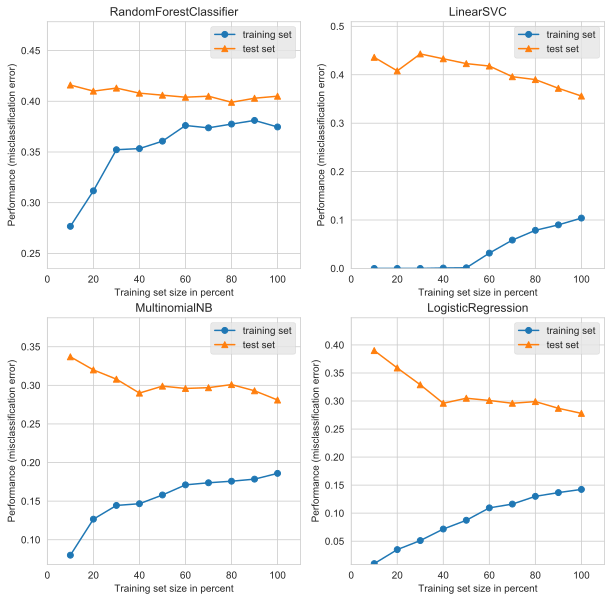

In [44]:
from mlxtend.plotting import plot_learning_curves
import itertools
import matplotlib.gridspec as gridspec

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(C=1400, dual=False, loss='squared_hinge', max_iter=1000, penalty='l2'),
    MultinomialNB(alpha=0.42, fit_prior=True),
    LogisticRegression(C=1, dual=False, multi_class='ovr', penalty='l2'),
]

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for model, grd in zip(models, grid):    
    model_name = model.__class__.__name__
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig2 = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, model, print_model=False, style='ggplot')
    plt.title(model_name)
         
plt.show()

---

## 2. b. Learning Curves: Training/Testing Accuracy - Optimized Hyperarameters

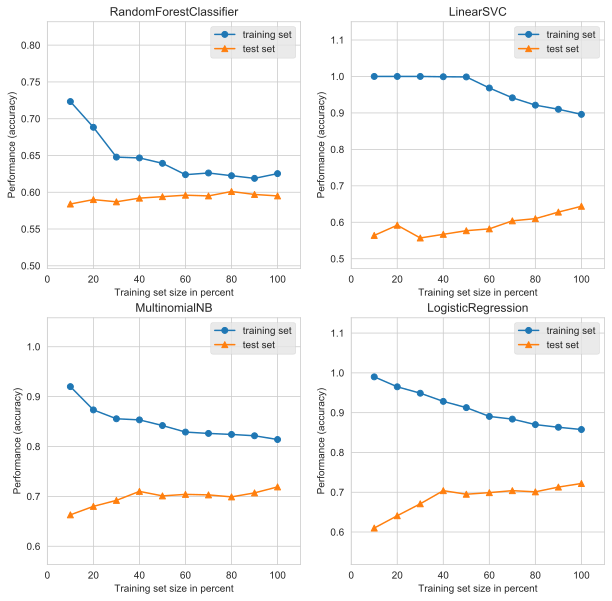

In [45]:
from mlxtend.plotting import plot_learning_curves
import matplotlib.gridspec as gridspec
import itertools

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(C=1400, dual=False, loss='squared_hinge', max_iter=1000, penalty='l2'),
    MultinomialNB(alpha=0.42, fit_prior=True),
    LogisticRegression(C=1, dual=False, multi_class='ovr', penalty='l2'),
]

#fig2 = plt.figure(figsize=(10, 10))
fig3 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for model, grd in zip(models, grid):    
    model_name = model.__class__.__name__
    ax = plt.subplot(gs[grd[0], grd[1]])
    #fig2 = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, model, print_model=False, style='ggplot')
    fig3 = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, model, scoring='accuracy', print_model=False, style='ggplot')
    plt.title(model_name)
         
plt.show()

### Learning Curves
The learning curves for training/testing indicated the following: low error and a high gap between the training and the validation curves.  This indicates:
+ High variance
+ Low bias

Increasing the number of samples gave us more convergence on our curves, but two of the models continue to indicate 100% validation indicating more samples are required.

---

## 3. Ensemble Learning

#### Initialize Models with optimized hyperparameters

In [46]:
clf1 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
clf2 = LinearSVC(C=1400, dual=False, loss='squared_hinge', max_iter=1000, penalty='l2')
clf3 = MultinomialNB(alpha=0.42, fit_prior=True)
clf4 = LogisticRegression(C=1, dual=False, multi_class='ovr', penalty='l2')

## Bagging

In [47]:
from sklearn.ensemble import BaggingClassifier

bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.8)
bagging3 = BaggingClassifier(base_estimator=clf3, n_estimators=10, max_samples=0.8)
bagging4 = BaggingClassifier(base_estimator=clf4, n_estimators=10, max_samples=0.8)

## Learning Curves for Bagged Models

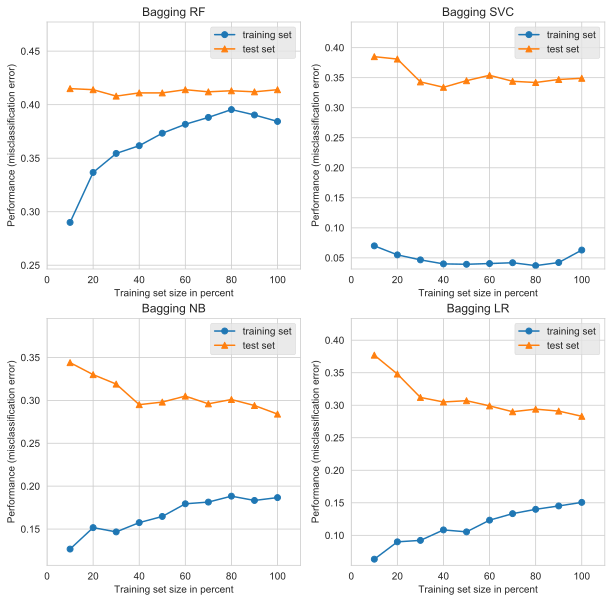

In [48]:
from mlxtend.plotting import plot_learning_curves

models = [
    bagging1, bagging2, bagging3, bagging4
]
labels = ['Bagging RF', 'Bagging SVC', 'Bagging NB','Bagging LR']

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for model, label, grd in zip(models, labels, grid):    
    model_name = model.__class__.__name__
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig2 = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, model, print_model=False, style='ggplot')
    plt.title(label)
         
plt.show()

## Bagging Scores Varied by Ensemble Size

---

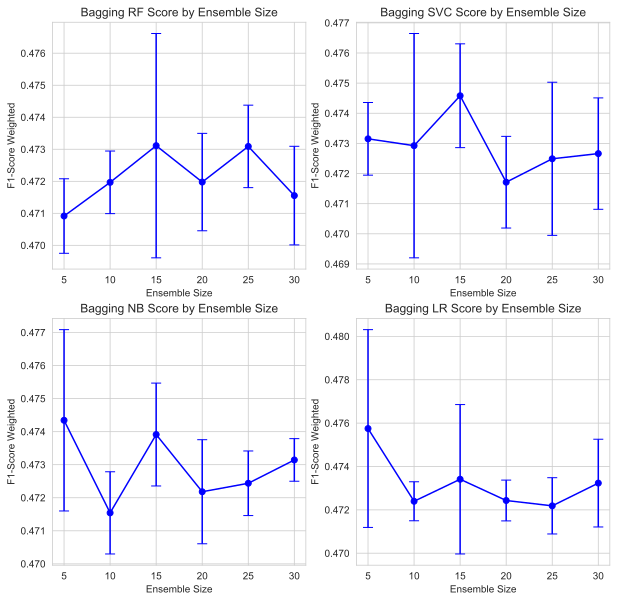

In [74]:
clf_list = [clf1, clf2, clf3, clf4]
labels = ['Bagging RF', 'Bagging SVC', 'Bagging NB','Bagging LR']

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, labels, grid):  
    num_est = map(int, np.linspace(5,30,6))
    bg_clf_cv_mean = []
    bg_clf_cv_std = []
    for n_est in num_est:    
        bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)
        scores = cross_val_score(bg_clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
        bg_clf_cv_mean.append(scores.mean())
        bg_clf_cv_std.append(scores.std())

    num_est = list(map(int, np.linspace(5,30,6)))
    ax = plt.subplot(gs[grd[0], grd[1]]) 

    (_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
    for cap in caps:
        cap.set_markeredgewidth(1)
                                                                                         
    fig2 = plt.ylabel('F1-Score Weighted'); plt.xlabel('Ensemble Size'); plt.title(label + ' Score by Ensemble Size');
plt.show()

In [51]:
bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=30, max_samples=0.9)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.7)
bagging3 = BaggingClassifier(base_estimator=clf3, n_estimators=20, max_samples=0.8)
bagging4 = BaggingClassifier(base_estimator=clf4, n_estimators=15, max_samples=0.7)

In [52]:
from mlxtend.plotting import plot_decision_regions
import itertools
import matplotlib.gridspec as gridspec

labels = ['Bagging RF', 'Bagging SVC', 'Bagging NB','Bagging LR']
clf_list = [bagging1, bagging2, bagging3, bagging4]

# fig = plt.figure(figsize=(10, 8))
# gs = gridspec.GridSpec(2, 4)
# grid = itertools.product([0,1],repeat=4)

#for clf, label, grd, model_id in zip(clf_list, labels, grid, model_ids):
for clf, label, model_id in zip(clf_list, labels, model_ids):          
    scores = cross_val_score(clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
    entries.append([model_id, label, 'optimized', 'tuned', '', scores.mean()])
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

Accuracy: 0.47 (+/- 0.00) [Bagging RF]
Accuracy: 0.67 (+/- 0.01) [Bagging SVC]
Accuracy: 0.73 (+/- 0.01) [Bagging NB]
Accuracy: 0.72 (+/- 0.01) [Bagging LR]


In [53]:
result_df = pd.DataFrame(entries, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])
models_df = result_df.groupby(['Model_Id','Model','Features','Hyper_Param', 'Best_Params']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

F1_Score_mean
Model_Id Model                  Features  Hyper_Param Best_Params                                                                                          
LR       Bagging LR             optimized tuned                                                                                                   0.7179472
         LogisticRegression     baseline  default                                                                                                 0.7412340
                                optimized default                                                                                                 0.7308755
                                          tuned       {'C': 1, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l2'}                              0.7286391
NB       Bagging NB             optimized tuned                                                                                                   0.7324950
         MultinomialNB          baseline  default                                                                                                 0.6233841
                                optimized default                                                                                                 0.7424195
                                          tuned       {'alpha': 0.42, 'fit_prior': True}                                                          0.7466944
RF       Bagging RF             optimized tuned                                                                                                   0.4727023
         RandomForestClassifier baseline  default                                                                                                 0.5875110
                                optimized default                                                                                                 0.6956293
                                          tuned       {'max_depth': 5, 'n_estimators': 100, 'random_state': 0}                                    0.4837150
SVC      Bagging SVC            optimized tuned                                                                                                   0.6672212
         LinearSVC              baseline  default                                                                                                 0.7196469
                                optimized default                                                                                                 0.7103931
                                          tuned       {'C': 1400, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'}      0.6479904

The Bagging ensemble did not provide any improvements on the baseline and optimized modeling.

## Boosting

In [54]:
from sklearn.ensemble import AdaBoostClassifier

boosting1 = AdaBoostClassifier(base_estimator=clf1)
boosting2 = AdaBoostClassifier(base_estimator=clf2, algorithm='SAMME')
boosting3 = AdaBoostClassifier(base_estimator=clf3)
boosting4 = AdaBoostClassifier(base_estimator=clf4)

## Boosting Scores Varied by Ensemble Size

F1-Score Weighted: 0.48 (+/- 0.00) [AdaBoost RF, n_estimators: 1]
F1-Score Weighted: 0.62 (+/- 0.01) [AdaBoost RF, n_estimators: 5]
F1-Score Weighted: 0.64 (+/- 0.00) [AdaBoost RF, n_estimators: 10]
F1-Score Weighted: 0.65 (+/- 0.01) [AdaBoost RF, n_estimators: 15]
F1-Score Weighted: 0.65 (+/- 0.01) [AdaBoost RF, n_estimators: 20]

F1-Score Weighted: 0.68 (+/- 0.01) [AdaBoost SVC, n_estimators: 1]
F1-Score Weighted: 0.68 (+/- 0.02) [AdaBoost SVC, n_estimators: 5]
F1-Score Weighted: 0.62 (+/- 0.00) [AdaBoost SVC, n_estimators: 10]
F1-Score Weighted: 0.67 (+/- 0.02) [AdaBoost SVC, n_estimators: 15]
F1-Score Weighted: 0.63 (+/- 0.00) [AdaBoost SVC, n_estimators: 20]

F1-Score Weighted: 0.47 (+/- 0.00) [AdaBoost NB, n_estimators: 1]
F1-Score Weighted: 0.52 (+/- 0.01) [AdaBoost NB, n_estimators: 5]
F1-Score Weighted: 0.58 (+/- 0.01) [AdaBoost NB, n_estimators: 10]
F1-Score Weighted: 0.59 (+/- 0.02) [AdaBoost NB, n_estimators: 15]
F1-Score Weighted: 0.58 (+/- 0.00) [AdaBoost NB, n_estimators

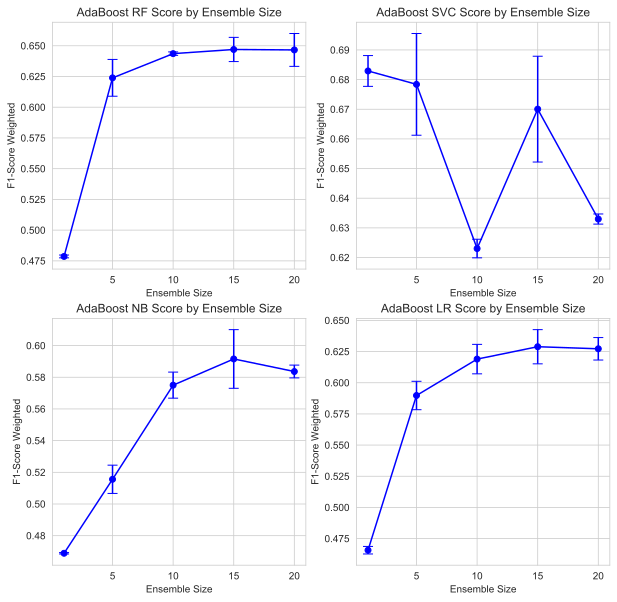

In [55]:
from sklearn.ensemble import AdaBoostClassifier

bst_list = [boosting1, boosting2, boosting3, boosting4]
labels = ['AdaBoost RF', 'AdaBoost SVC', 'AdaBoost NB','AdaBoost LR']

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

num_est = map(int, np.linspace(5,30,6))

for boosting, label, grd in zip(bst_list, labels, grid):  
    num_est = map(int, np.linspace(1,20,5))
    bg_clf_cv_mean = []
    bg_clf_cv_std = []
    for n_est in num_est:
        boosting.set_params(n_estimators=n_est)
        scores = cross_val_score(boosting, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
        bg_clf_cv_mean.append(scores.mean())
        bg_clf_cv_std.append(scores.std())
        print("F1-Score Weighted: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label + ', n_estimators: ' + str(n_est)))
    
    ax = plt.subplot(gs[grd[0], grd[1]]) 
    num_est = list(map(int, np.linspace(1,20,5)))
    (_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
    for cap in caps:
        cap.set_markeredgewidth(1)                                                                                                                                
    fig2 = plt.ylabel('F1-Score Weighted'); plt.xlabel('Ensemble Size'); plt.title(label + ' Score by Ensemble Size');
    print('')


## Learning Curves for Boosted Models

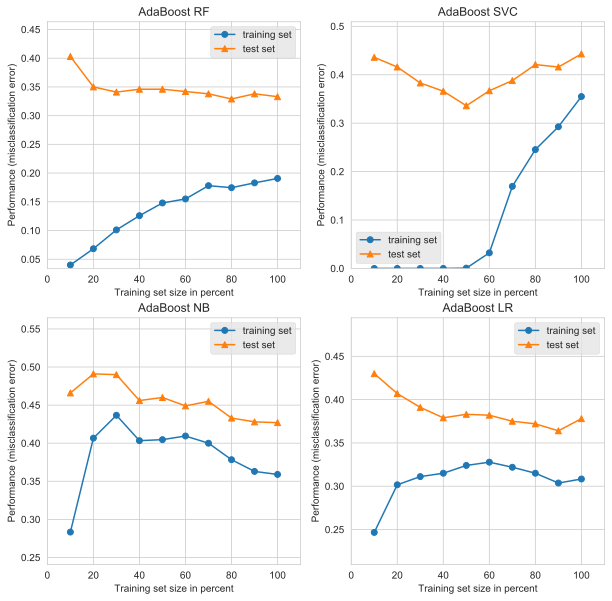

In [56]:
#plot Boosting learning curve
fig_bst = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for boosting, label, grd in zip(bst_list, labels, grid):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig_bst = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, boosting, print_model=False, style='ggplot')
    plt.title(label)
plt.show()

In [57]:
boosting1 = AdaBoostClassifier(base_estimator=clf1, n_estimators=5)
boosting2 = AdaBoostClassifier(base_estimator=clf2, n_estimators=15, algorithm='SAMME')
boosting3 = AdaBoostClassifier(base_estimator=clf3, n_estimators=20)
boosting4 = AdaBoostClassifier(base_estimator=clf4, n_estimators=5)
boost_list = [boosting1, boosting2, boosting3, boosting4]
labels_bst = ['AdaBoost RF', 'AdaBoost SVC', 'AdaBoost NB','AdaBoost LR']

In [58]:
from sklearn.ensemble import AdaBoostClassifier

labels = ['AdaBoost RF', 'AdaBoost SVC', 'AdaBoost NB','AdaBoost LR']
bst_list = [boosting1, boosting2, boosting3, boosting4]

for boosting, label, model_id in zip(bst_list, labels, model_ids):
    
    scores = cross_val_score(boosting, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
    entries.append([model_id, label, 'optimized', 'tuned', '', scores.mean()])
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

Accuracy: 0.62 (+/- 0.01) [AdaBoost RF]
Accuracy: 0.67 (+/- 0.02) [AdaBoost SVC]
Accuracy: 0.58 (+/- 0.00) [AdaBoost NB]
Accuracy: 0.59 (+/- 0.01) [AdaBoost LR]


In [59]:
result_df = pd.DataFrame(entries, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])
models_df = result_df.groupby(['Model_Id','Model','Features','Hyper_Param', 'Best_Params']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

F1_Score_mean
Model_Id Model                  Features  Hyper_Param Best_Params                                                                                          
LR       AdaBoost LR            optimized tuned                                                                                                   0.5897683
         Bagging LR             optimized tuned                                                                                                   0.7179472
         LogisticRegression     baseline  default                                                                                                 0.7412340
                                optimized default                                                                                                 0.7308755
                                          tuned       {'C': 1, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l2'}                              0.7286391
NB       AdaBoost NB            optimized tuned                                                                                                   0.5836239
         Bagging NB             optimized tuned                                                                                                   0.7324950
         MultinomialNB          baseline  default                                                                                                 0.6233841
                                optimized default                                                                                                 0.7424195
                                          tuned       {'alpha': 0.42, 'fit_prior': True}                                                          0.7466944
RF       AdaBoost RF            optimized tuned                                                                                                   0.6225026
         Bagging RF             optimized tuned                                                                                                   0.4727023
         RandomForestClassifier baseline  default                                                                                                 0.5875110
                                optimized default                                                                                                 0.6956293
                                          tuned       {'max_depth': 5, 'n_estimators': 100, 'random_state': 0}                                    0.4837150
SVC      AdaBoost SVC           optimized tuned                                                                                                   0.6700429
         Bagging SVC            optimized tuned                                                                                                   0.6672212
         LinearSVC              baseline  default                                                                                                 0.7196469
                                optimized default                                                                                                 0.7103931
                                          tuned       {'C': 1400, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'}      0.6479904

The Boosting ensemble did not provide any improvements on the baseline and optimized modeling.

## Stacking

In [60]:
from mlxtend.classifier import StackingClassifier

sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=clf4)

labels = ['Random Forest', 'LinearSVC', 'MultinomialNB', 'Stacking LR']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, labels, grid):
        
    scores = cross_val_score(clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    if (label == 'Stacking LR'):
        entries.append(['Stack', label, 'optimized', 'tuned', '', scores.mean()])
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())

Accuracy: 0.62 (+/- 0.00) [Random Forest]
Accuracy: 0.62 (+/- 0.01) [LinearSVC]
Accuracy: 0.75 (+/- 0.01) [MultinomialNB]
Accuracy: 0.54 (+/- 0.00) [Stacking LR]


<Figure size 1000x800 with 0 Axes>

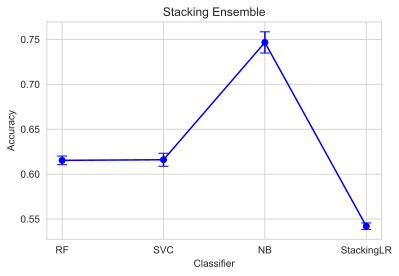

In [61]:
#plot classifier accuracy    
plt.figure()
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.xticks(range(4), ['RF', 'SVC', 'NB', 'StackingLR'])        
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

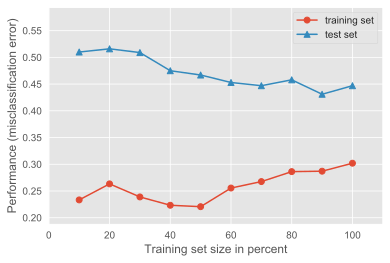

In [62]:
#plot Stacking learning curve
plt.figure()
plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, sclf, print_model=False, style='ggplot')
plt.show()

In [63]:
from mlxtend.classifier import StackingClassifier

sclf_bst = StackingClassifier(classifiers=[boosting1, boosting2, boosting3], meta_classifier=clf4)

labels = ['Boosted RF', 'Boosted SVC', 'Boosted NB', 'Stacking Boosted LR']
#clf_list = [clf1, clf2, clf3, sclf]
bst_list = [boosting1, boosting2, boosting3, sclf_bst]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(bst_list, labels, grid):
        
    scores = cross_val_score(clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    if (label == 'Stacking Boosted LR'):
        entries.append(['Stack', label, 'optimized', 'tuned', '', scores.mean()])
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())

Accuracy: 0.68 (+/- 0.01) [Boosted RF]
Accuracy: 0.67 (+/- 0.02) [Boosted SVC]
Accuracy: 0.61 (+/- 0.00) [Boosted NB]
Accuracy: 0.50 (+/- 0.02) [Stacking Boosted LR]


<Figure size 1000x800 with 0 Axes>

In [64]:
result_df = pd.DataFrame(entries, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])
models_df = result_df.groupby(['Model_Id', 'Model','Features','Hyper_Param', 'Best_Params']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

F1_Score_mean
Model_Id Model                  Features  Hyper_Param Best_Params                                                                                          
LR       AdaBoost LR            optimized tuned                                                                                                   0.5897683
         Bagging LR             optimized tuned                                                                                                   0.7179472
         LogisticRegression     baseline  default                                                                                                 0.7412340
                                optimized default                                                                                                 0.7308755
                                          tuned       {'C': 1, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l2'}                              0.7286391
NB       AdaBoost NB            optimized tuned                                                                                                   0.5836239
         Bagging NB             optimized tuned                                                                                                   0.7324950
         MultinomialNB          baseline  default                                                                                                 0.6233841
                                optimized default                                                                                                 0.7424195
                                          tuned       {'alpha': 0.42, 'fit_prior': True}                                                          0.7466944
RF       AdaBoost RF            optimized tuned                                                                                                   0.6225026
         Bagging RF             optimized tuned                                                                                                   0.4727023
         RandomForestClassifier baseline  default                                                                                                 0.5875110
                                optimized default                                                                                                 0.6956293
                                          tuned       {'max_depth': 5, 'n_estimators': 100, 'random_state': 0}                                    0.4837150
SVC      AdaBoost SVC           optimized tuned                                                                                                   0.6700429
         Bagging SVC            optimized tuned                                                                                                   0.6672212
         LinearSVC              baseline  default                                                                                                 0.7196469
                                optimized default                                                                                                 0.7103931
                                          tuned       {'C': 1400, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'}      0.6479904
Stack    Stacking Boosted LR    optimized tuned                                                                                                   0.4953333
         Stacking LR            optimized tuned                                                                                                   0.5420000

The Stacking performed poorly on our modeling.

---

## Summary of Findings

#### Benchmarking of F1 Scores of Models for Baseline, Bagging, Boosting and Stacking

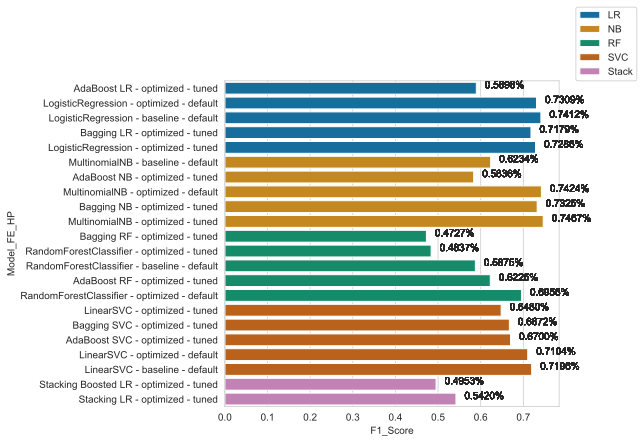

In [72]:
result_df['Model_FE_HP'] = result_df['Model'] + ' - ' + result_df['Features'] + ' - ' + result_df['Hyper_Param']
#fig = plt.subplots(figsize=(6, 6))
fig, (ax1) = plt.subplots(figsize=(6, 6), ncols=1)
g = sns.barplot(x='F1_Score', y='Model_FE_HP', data=result_df.sort_values(by=['Model_Id','F1_Score']), palette="colorblind", hue='Model_Id', dodge=False, ci=None, ax=ax1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)

total = len(result_df['Model_FE_HP'])
def annotateBars(row, ax=ax): 
    for p in ax.patches:
        val = '{:.4f}%'.format(p.get_width())
        #percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(val, (x, y))

plot = result_df.apply(annotateBars, ax=ax1, axis=1)
plt.show()


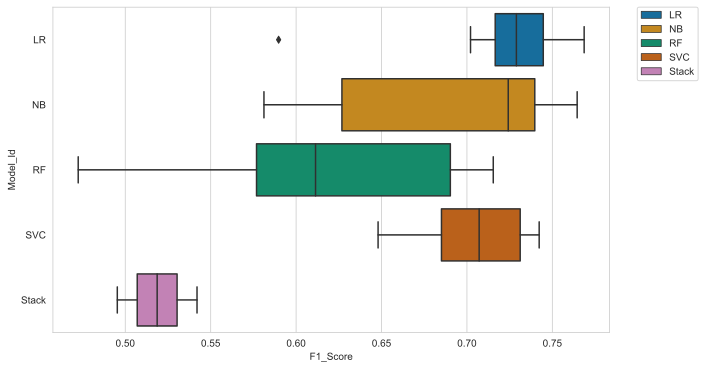

In [66]:
fig = plt.subplots(figsize=(10, 6))
sns.boxplot(x='F1_Score', y='Model_Id', data=result_df.sort_values(by='Model_Id'), palette="colorblind", hue='Model_Id', dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

#### Model Evaluation Results with F1 Score

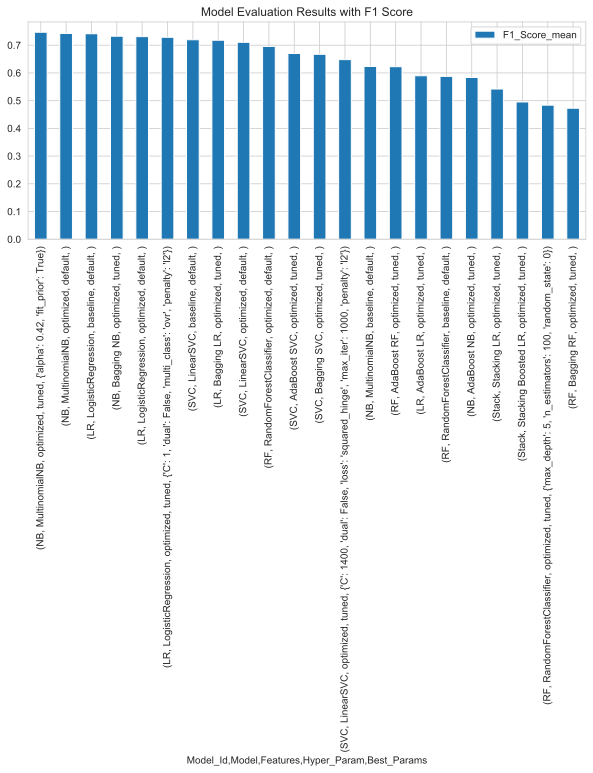

In [67]:
models_df.sort_values(by='F1_Score_mean', ascending=False).\
plot(y="F1_Score_mean", kind='bar', title="Model Evaluation Results with F1 Score", figsize=(10, 4));

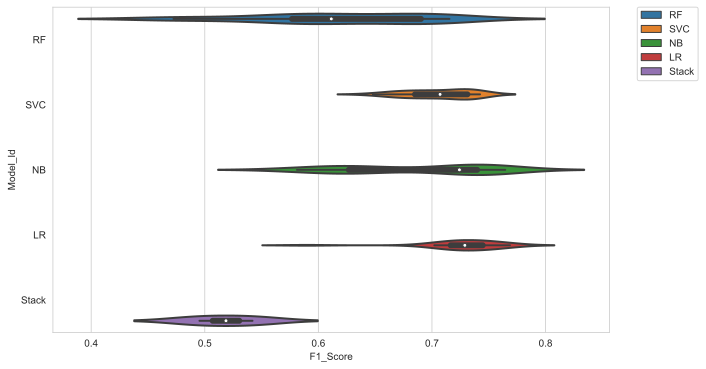

In [73]:
fig = plt.subplots(figsize=(10, 6))
#sns.boxplot(x='F1_Score', y='Model_Id', data=result_df.sort_values(by='Model_Id'), palette="colorblind", hue='Model_Id', dodge=False)
sns.violinplot(x='F1_Score', y='Model_Id', data=result_df, hue='Model_Id', size=6, jitter=True, edgecolor="gray", linewidth=2);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);